# Trabalho de IA - Parte 2: Análise Exploratória (EDA)

**Dataset:** Olist E-Commerce
**Objetivo:** Compreender a estrutura dos dados, realizar a união (merge) das tabelas relacionais e justificar estatisticamente as escolhas de pré-processamento (especialmente o balanceamento de classes).


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuração visual
sns.set_style("whitegrid")

# Define o caminho (assumindo que o notebook está em /notebooks e os dados em /data/raw)
DATA_PATH = "../data/raw/"

try:
    print(f"Arquivos na pasta: {os.listdir(DATA_PATH)}")
except FileNotFoundError:
    print(f"❌ Diretório não encontrado: {DATA_PATH}")
    print("Verifique se está a rodar o notebook a partir da pasta correta.")

Arquivos na pasta: ['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


In [12]:
# Carregar os principais CSVs
try:
    customers = pd.read_csv(os.path.join(DATA_PATH, "olist_customers_dataset.csv"))
    orders = pd.read_csv(os.path.join(DATA_PATH, "olist_orders_dataset.csv"))
    items = pd.read_csv(os.path.join(DATA_PATH, "olist_order_items_dataset.csv"))
    products = pd.read_csv(os.path.join(DATA_PATH, "olist_products_dataset.csv"))
    payments = pd.read_csv(os.path.join(DATA_PATH, "olist_order_payments_dataset.csv"))
    
    print("✅ Arquivos CSV carregados com sucesso.")
except FileNotFoundError as e:
    print(f"Erro ao carregar CSV: {e}")

✅ Arquivos CSV carregados com sucesso.


## 1. Unificação das Tabelas (Data Merging)

O dataset Olist é relacional. Para treinar modelos de ML, precisamos de uma visão "achatada" (tabela única) onde cada linha representa um item de um pedido com todas as suas características associadas.

**Estratégia de Join:**

* `orders` → `customers` (via `customer_id`)
* `orders` → `items` (via `order_id`)
* `items` → `products` (via `product_id`)
* `orders` → `payments` (via `order_id`)

In [13]:
# 1. Juntar pedidos com clientes
df = pd.merge(orders, customers, on="customer_id", how="left")

# 2. Juntar os itens de cada pedido
df = pd.merge(df, items, on="order_id", how="left")

# 3. Juntar os produtos de cada item
df = pd.merge(df, products, on="product_id", how="left")

# 4. Juntar os pagamentos
df = pd.merge(df, payments, on="order_id", how="left")

print(f"Shape do dataset unificado: {df.shape}")
df.head(3)

Shape do dataset unificado: (118434, 30)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,2.0,voucher,1.0,18.59


In [14]:
# Verificar tipos de dados e nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   customer_unique_id             118434 non-null  object 
 9   customer_zip_code_prefix       118434 non-null  int64  
 10  customer_city                  118434 non-null  object 
 11  customer_state                 118434 non-null  object 
 12  order_item_id                 

## 2. Análise da Variável Alvo (Target)

O nosso objetivo é prever **atrasos na entrega**. Para isso, criamos a feature `is_late` comparando a data de entrega real com a estimada.

**Justificativa Técnica:** A análise abaixo demonstra o severo desbalanceamento das classes.

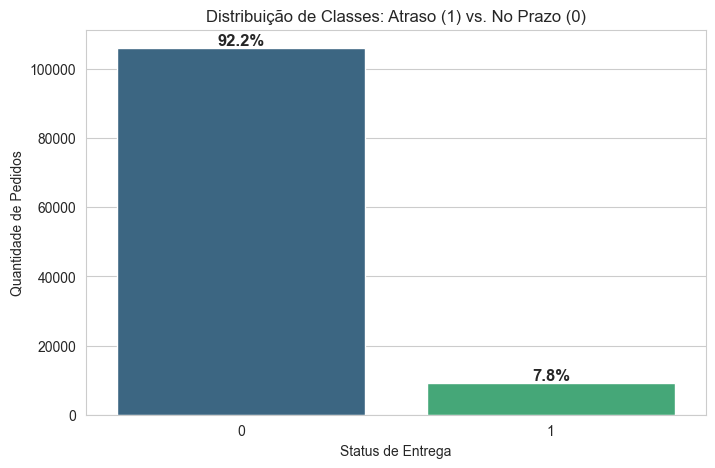

Taxa global de atrasos: 7.85%


In [15]:
# Converter colunas de data para datetime
cols_date = ['order_delivered_customer_date', 'order_estimated_delivery_date']
for col in cols_date:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Remover linhas sem data de entrega (pedidos cancelados ou em trânsito)
df_clean = df.dropna(subset=cols_date).copy()

# Criar Target: 1 se atrasou, 0 se chegou no prazo
df_clean['is_late'] = (df_clean['order_delivered_customer_date'] > df_clean['order_estimated_delivery_date']).astype(int)

# Visualizar Desbalanceamento
plt.figure(figsize=(8, 5))

# CORREÇÃO AQUI: Adicionado hue='is_late' e legend=False para evitar o aviso
ax = sns.countplot(x='is_late', data=df_clean, hue='is_late', palette='viridis', legend=False)

plt.title('Distribuição de Classes: Atraso (1) vs. No Prazo (0)')
plt.xlabel('Status de Entrega')
plt.ylabel('Quantidade de Pedidos')

# Adicionar percentagens
total = len(df_clean)
for p in ax.patches:
    height = p.get_height()
    # Verifica se há dados para evitar erro em barras vazias
    if height > 0:
        percentage = '{:.1f}%'.format(100 * height/total)
        x = p.get_x() + p.get_width()/2
        y = height
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

print(f"Taxa global de atrasos: {df_clean['is_late'].mean():.2%}")

### 📌 Conclusão sobre o Target
Observamos que **menos de 8% dos pedidos sofrem atraso**.
* **Problema:** Se usarmos os dados brutos, um modelo "preguiçoso" que preveja sempre "Não Atrasou" terá 92% de Acurácia, mas 0% de Recall para atrasos.
* **Decisão:** Isso justifica o uso de **Undersampling** (balanceamento 50/50) na etapa de pré-processamento (`src/part2_ml/preprocess.py`) para forçar o modelo a aprender as características do atraso.
## 3. Hipótese Geográfica
Será que a localização do cliente influencia o atraso?

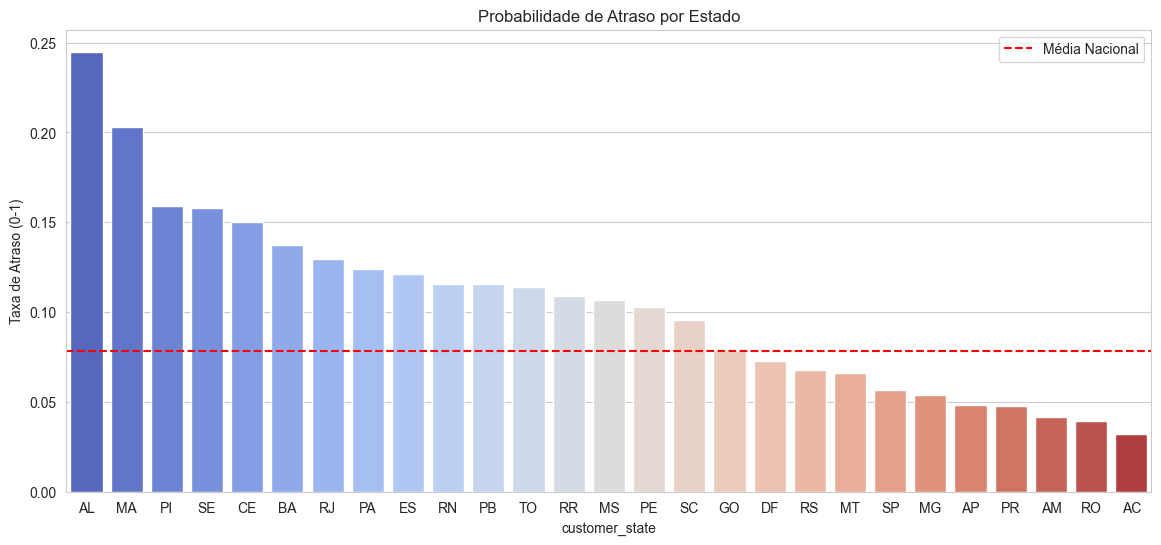

In [16]:
# Calcular taxa de atraso média por estado
state_delay = df_clean.groupby('customer_state')['is_late'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 6))

# CORREÇÃO AQUI: Adicionado hue='customer_state' e legend=False
sns.barplot(x='customer_state', y='is_late', data=state_delay, hue='customer_state', palette='coolwarm', legend=False)

plt.axhline(y=df_clean['is_late'].mean(), color='r', linestyle='--', label='Média Nacional')
plt.title('Probabilidade de Atraso por Estado')
plt.ylabel('Taxa de Atraso (0-1)')
plt.legend()
plt.show()

### 📌 Análise Geográfica
Estados mais remotos (como AL, MA, SE) apresentam taxas de atraso significativamente superiores à média nacional e aos estados do Sul/Sudeste (SP, PR).
* **Decisão:** A feature `customer_state` é discriminante e **deve ser mantida** no treino do modelo.
## 4. Correlações Numéricas
Existe relação linear forte entre preço, frete, peso e o atraso?

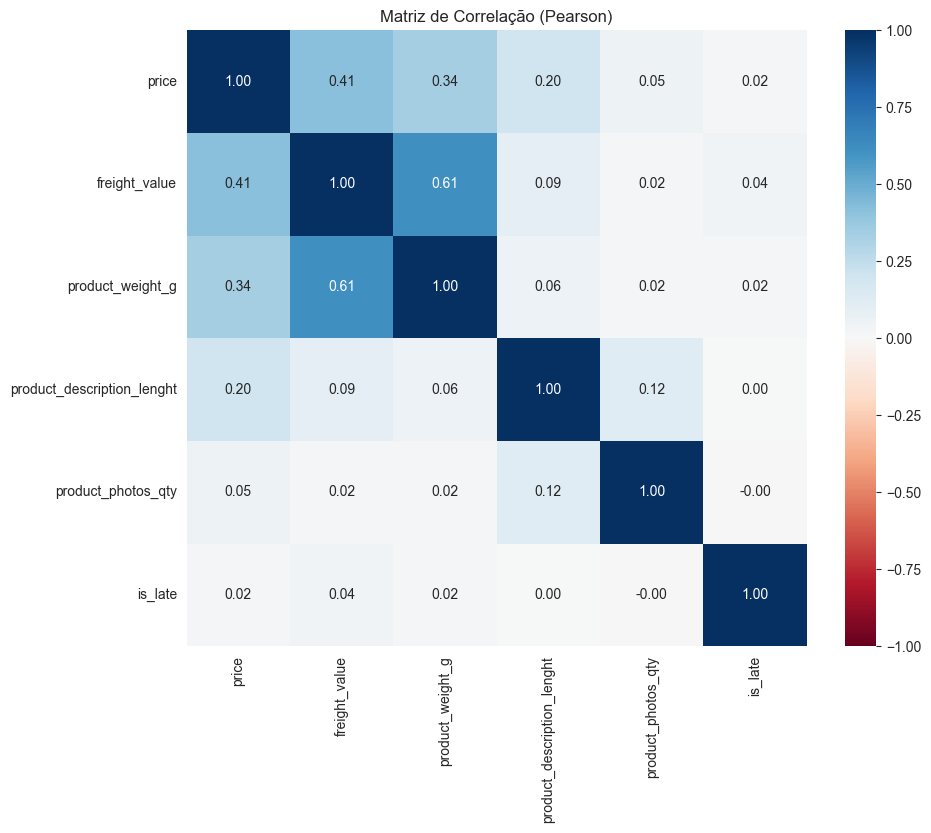

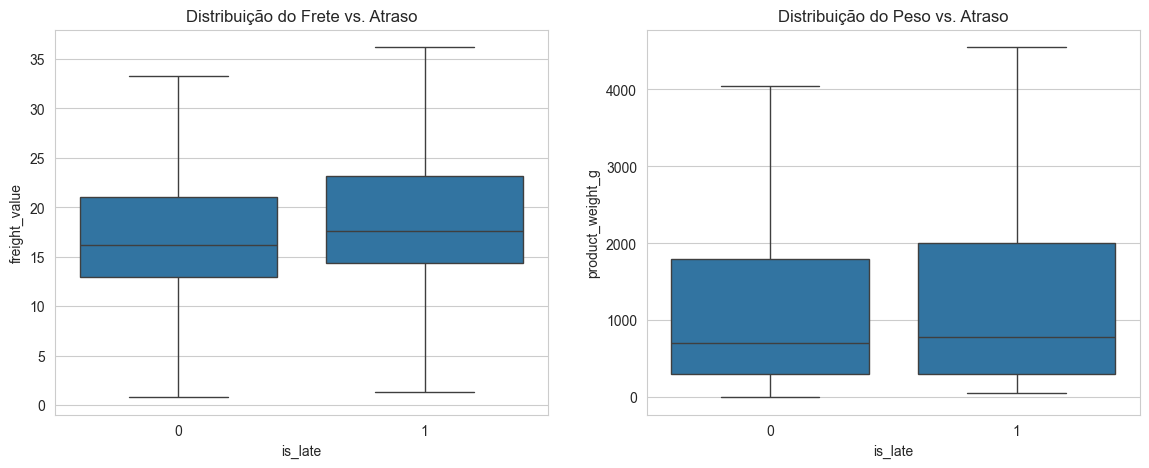

In [17]:
# Selecionar features numéricas relevantes
cols_num = ['price', 'freight_value', 'product_weight_g', 
             'product_description_lenght', 'product_photos_qty', 'is_late']

# Matriz de Correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[cols_num].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f")
plt.title('Matriz de Correlação (Pearson)')
plt.show()

# Boxplots para comparação visual
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='is_late', y='freight_value', data=df_clean, showfliers=False)
plt.title('Distribuição do Frete vs. Atraso')

plt.subplot(1, 2, 2)
sns.boxplot(x='is_late', y='product_weight_g', data=df_clean, showfliers=False)
plt.title('Distribuição do Peso vs. Atraso')

plt.show()

## 5. Conclusão Geral da EDA

1.  **Dificuldade do Problema:** As correlações lineares com o alvo `is_late` são muito baixas (próximas de zero). Isso indica que o atraso não é facilmente explicado apenas pelo peso ou preço do produto. Provavelmente depende de fatores logísticos externos não presentes na base (ex: greves, problemas operacionais dos correios).
2.  **Expectativa de Resultados:** Devido à baixa correlação e à complexidade "oculta", é esperado que modelos preditivos (KNN, SVM, Árvore) tenham dificuldade em atingir acurácias muito altas (>70%). O resultado em torno de 55-60% obtido nos experimentos está condizente com a natureza aleatória dos atrasos neste dataset.